# Need to see if all entries of a new matrixhave a factor of the product $P$ in them.

The product is $P =  (v_1^2 + v_2^2)(w_1^2 + w_2^2)$  where the values are the entries of the eigenvectors $v$ and $w$ of underlying matrix 

$$ Q = \begin{pmatrix}A & B \\ C & D \end{pmatrix}.$$

Formed in the standard way these vectors are given by

$$ v = \begin{pmatrix} B \\ \lambda_1 - A\end{pmatrix}, \qquad w = \begin{pmatrix} B \\ \lambda_2 - A\end{pmatrix}.$$

The new matrix we are examining is 

$$R = \lambda_2 (w^Tw)( vv^T) + \lambda_1 (v^Tv)(ww^T) = \lambda_2 (w_1^2 + w_2^2) \begin{bmatrix}v_1^2 & v_1v_2 \\ v_1v_2 & v_2^2\end{bmatrix} +  \lambda_1 (v_1^2 + v_2^2) \begin{bmatrix}w_1^2 & w_1w_2 \\ w_1w_2 & w_2^2\end{bmatrix}.$$

We actually know from previous work that the off-diagonal entries do have a factor of $P$ in them and we have

$$R_{1,2} = R_{2,1} = (\det Q) P.$$

We want the other two to have a factor as well so we can cancel it and have a great result, but it's being tricky.  Here I'll do some sympy and other investigations to hopefully get somewhere.  We're going to follow the notation in my handwritten notebook though and use $$v_1, v_2 = A_1, A_2 \qquad w_1, w_2 = B_1, B_2.$$  Also, the entries of $Q$ are given by

$$ Q = \begin{pmatrix}2ac & 2ad \\ 2ad & 2bd \end{pmatrix}.$$

where $$M = \begin{pmatrix}a & b \\ c & d \end{pmatrix}$$ is the transmission matrix of the waveguide.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import newton
from slab import SlabExact, plot_complex, plot_complex_surface
plt.style.use('dark_background')
%matplotlib widget

Before doing sympy, let's do some calculation and plotting to see if we think this is even true.

In [2]:
A = SlabExact(scale=1e-5, Ts=[6.5, 1, 8, 2.5, 6.5],
      ns=[1, 1.44, 1, 1.44, 1], xrefs=[100, 40, 300, 40, 100],
      symmetric=True, wl=6.9e-6, Shift=0)

In [61]:
def check(C):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    M = A.transmission_matrix(C)
    
    trQ =2 * ( M[..., 0, 0] * M[..., 1, 0] + \
        M[..., 0, 1] * M[..., 1, 1])

    detQ = -4 * M[..., 0, 0] * M[..., 1, 1]
    
    disc = np.sqrt(trQ**2 - 4 * detQ, dtype=complex)
    
    L1 = (trQ + disc) / 2
    L2 = (trQ - disc) / 2

    A1 = 2 * M[..., 0, 0] * M[..., 1, 1]
    A2 = L1 - 2 * M[..., 0, 0] * M[..., 1, 0]

    B1 = 2 * M[..., 0, 0] * M[..., 1, 1]
    B2 = L2 - 2 * M[..., 0, 0] * M[..., 1, 0]

    P = (A1**2 + A2**2) * (B1**2 + B2**2)
    term = L2 * (B1**2 + B2**2) * A1**2 + L1 * (A1**2 + A2**2) * B1**2
    return term / P

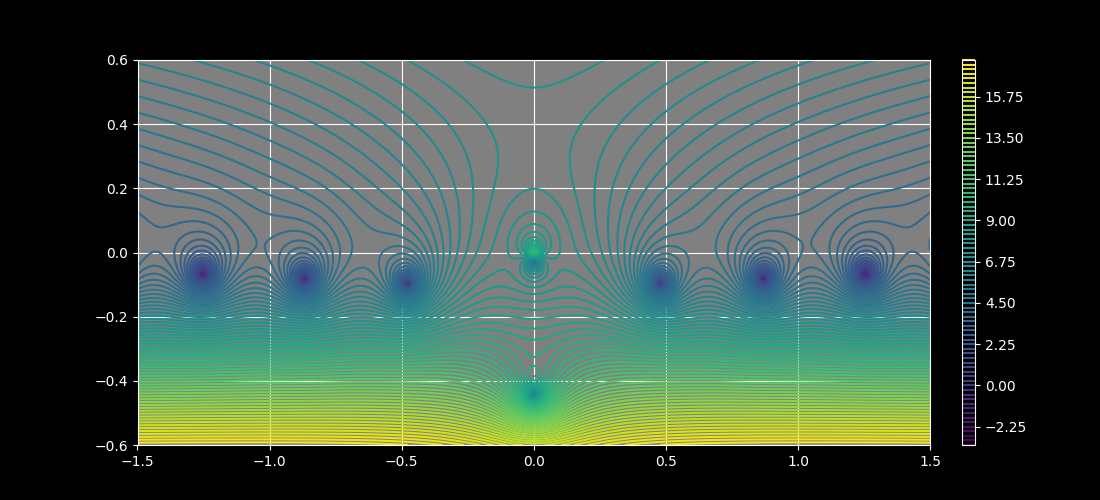

In [62]:
plot_complex(check, -1.5, 1.5, -.6, .6, iref=200, rref=200, levels=100)

This looks nice, also looks like the guided mode propagation constant plot.

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

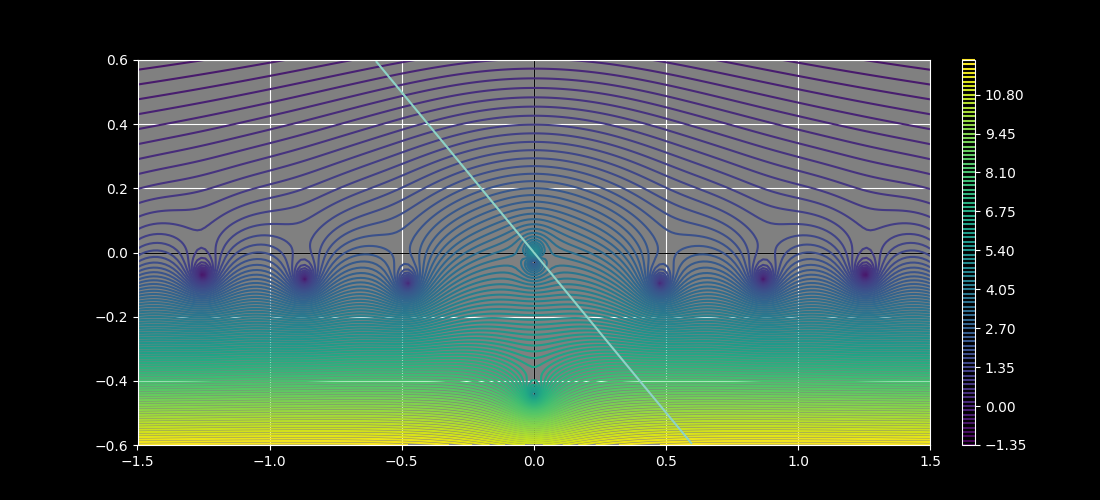

In [5]:
A.determinant_plot(-1.5, 1.5, -.6, .6, iref=200, rref=200, levels=100)

Grabbing some guided mode zeroes:

In [6]:
Zs_det = np.array([newton(A.determinant, np.array(.5 - .1j))[0], newton(A.determinant, np.array(-.4j))[0]])
A.plot_points(Zs_det)

But when we zoom in on the check function at a zero we see there is more going on:

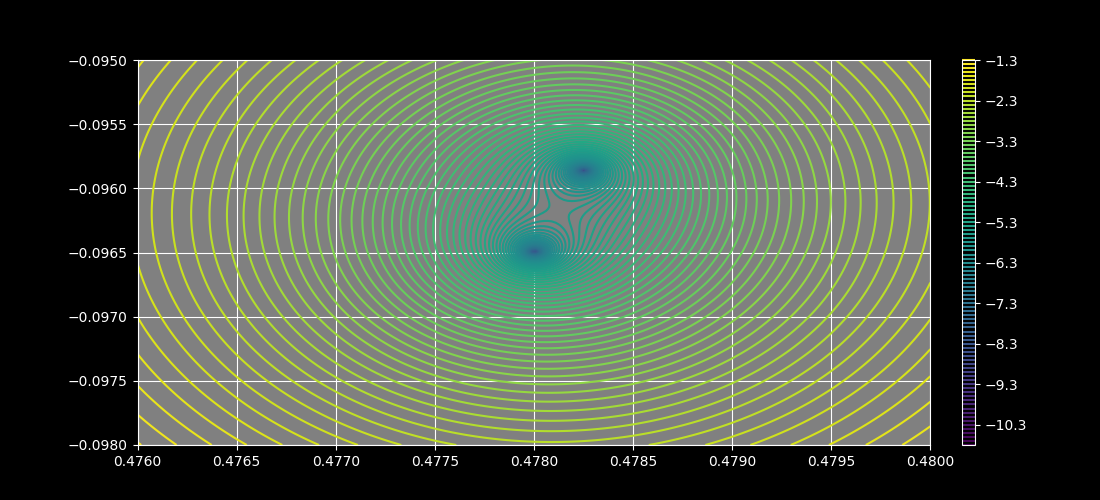

In [8]:
plot_complex(check, .476, .48,  -.098, -.095, iref=200, rref=200, levels=100)

In [9]:
A.plot_points(Zs_det[0])

In fact, it looks a lot like there is a copy of the guided mode component with an off diagonal part of the transmission matrix.

In [10]:
def Midx(C):
    M = A.transmission_matrix(C)
    return M[...,1, 1] * M[..., 0,1]

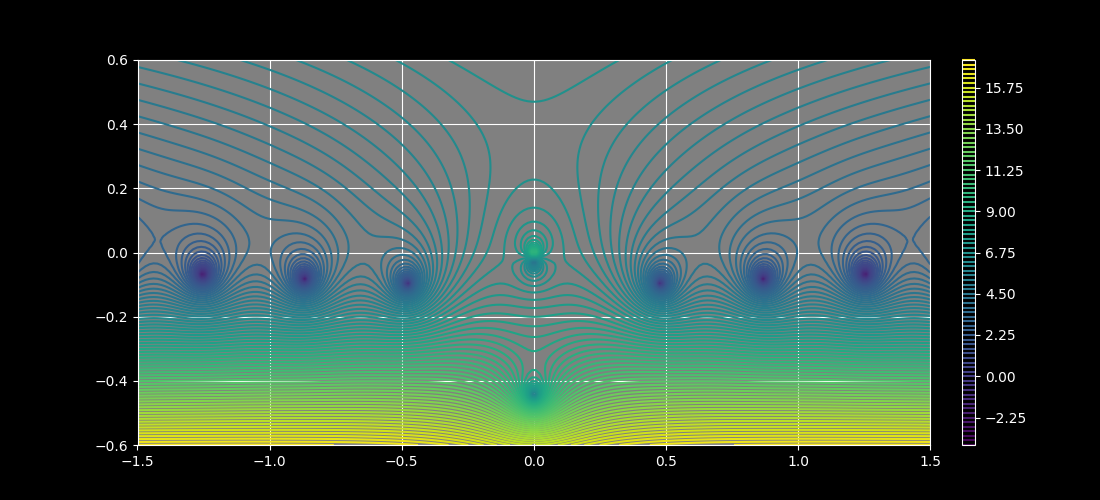

In [11]:
plot_complex(Midx, -1.5, 1.5, -.6, .6, iref=200, rref=200, levels=100)

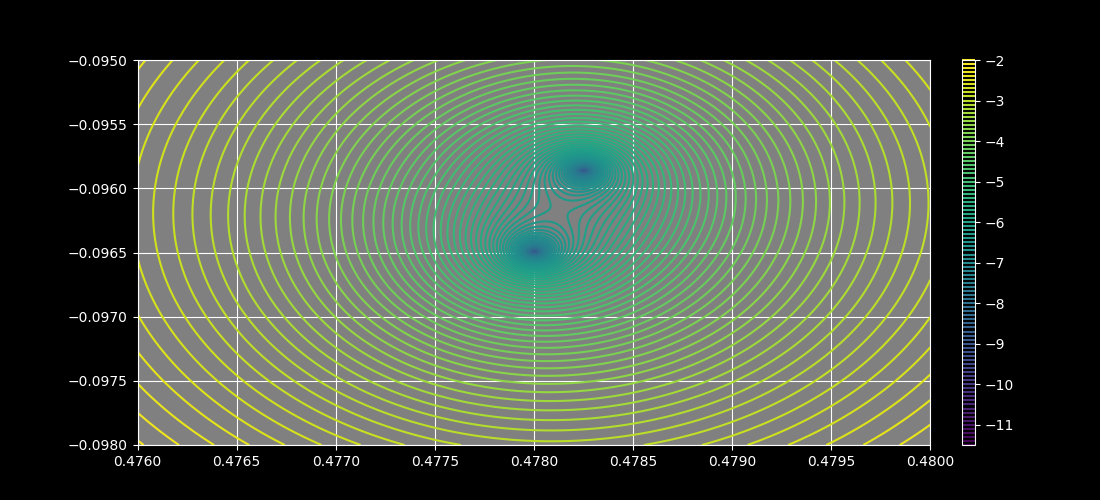

In [12]:
plot_complex(Midx, .476, .48,  -.098, -.095, iref=200, rref=200, levels=100)

Yeah that looks to be the thing.  Let's check the ratio of these two:

In [63]:
def ratio(C):
    return check(C) / Midx(C)

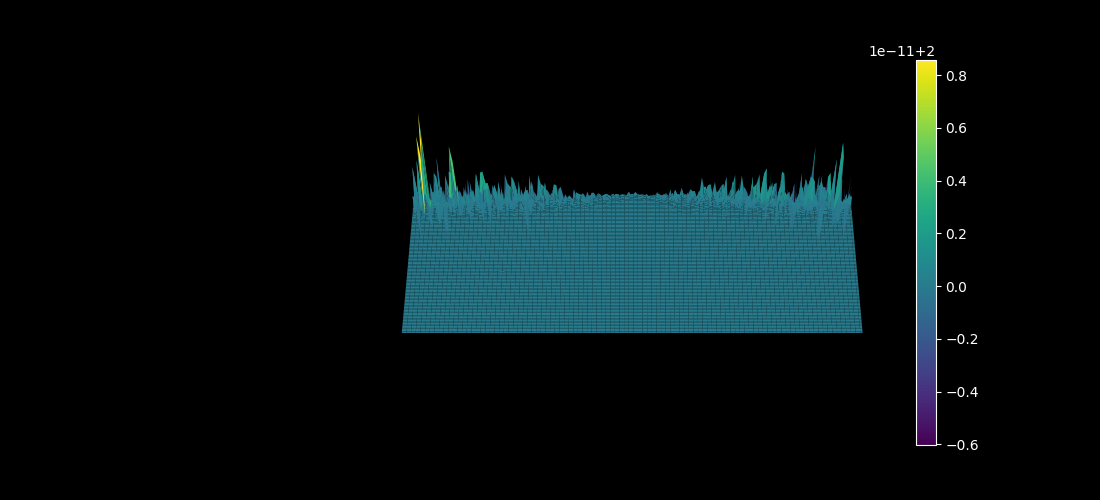

In [64]:
plot_complex_surface(ratio, -1.5, 1.5, -.6, .6, iref=200, rref=200)

In [65]:
ratio(1)

array([2.-3.03207163e-16j])

Basically correct, just missing a factor of two.  So (term / P) / (M11 * M01) = 2  so term = 2bdP

### Observations:

It  looks like the term of interest is equal to $2bdP$.  This is a bit uncanny because the off diagonal term was equal to $2adP$.  If the last term is equal to $2acP$, then this matrix will be very much like $Q$ scaled by $P$.

Just check other term while we're here:

In [71]:
def check2(C):
    try:
        len(C)
        C = np.asanyarray(C)
    except TypeError:
        C = np.asanyarray([C])

    M = A.transmission_matrix(C)
    
    trQ =2 * ( M[..., 0, 0] * M[..., 1, 0] + \
        M[..., 0, 1] * M[..., 1, 1])

    detQ = -4 * M[..., 0, 0] * M[..., 1, 1]
    
    disc = np.sqrt(trQ**2 - 4 * detQ, dtype=complex)
    
    L1 = (trQ + disc) / 2
    L2 = (trQ - disc) / 2

    A1 = 2 * M[..., 0, 0] * M[..., 1, 1]
    A2 = L1 - 2 * M[..., 0, 0] * M[..., 1, 0]

    B1 = 2 * M[..., 0, 0] * M[..., 1, 1]
    B2 = L2 - 2 * M[..., 0, 0] * M[..., 1, 0]

    P = (A1**2 + A2**2) * (B1**2 + B2**2)
    term = L2 * (B1**2 + B2**2) * A1 * A2 + L1 * (A1**2 + A2**2) * B1 * B2
    return term / P

In [72]:
def Midx2(C):
    M = A.transmission_matrix(C)
    return M[..., 0, 0] * M[..., 1, 1]

In [73]:
def ratio2(C):
    return check2(C) / Midx2(C)

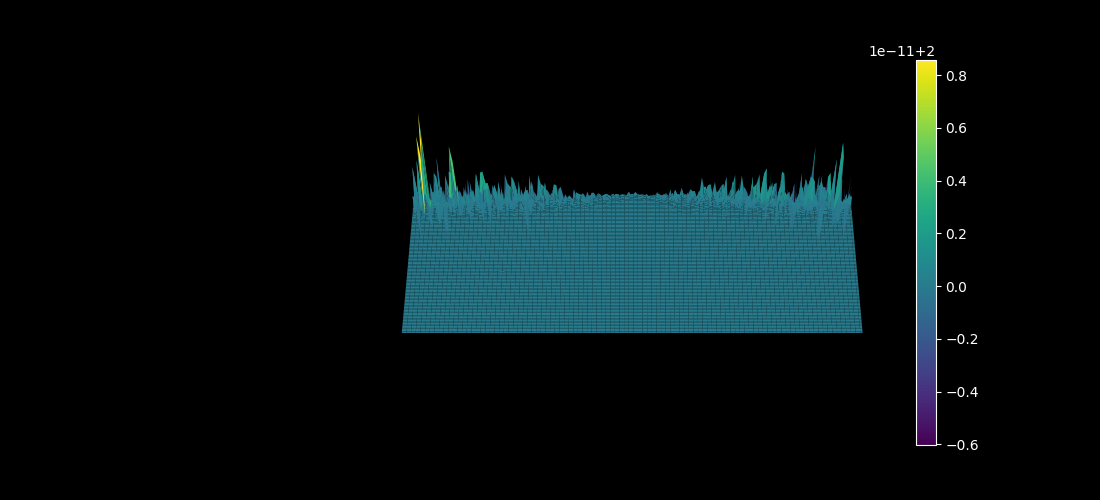

In [74]:
plot_complex_surface(ratio, -1.5, 1.5, -.6, .6, iref=200, rref=200)

In [75]:
ratio2(1)

array([-2.+2.55427999e-17j])

## Conclusions:

- First diagonal term appears equal to $2bdP$.

- Second diagonal term is equal to $2acP$.

- Off diagonal term is equal to $-2adP$

- Matrix is very much like $Q^{-1}$ scaled by $P$.  In fact, when you include the denominator of the spectral integrand, which is $\det Q$, the integrand is given by $E^T_x Q^{-1} E_s$ (after including necessary factor of $1/2\pi$ and canceling $P$).

## Sympy part

Okay, let's get symbolic.

In [76]:
a, b, c, d = sp.symbols('a b c d')
L1_s, L2_s = sp.symbols('lambda_1 lambda_2')

In [77]:
A1 = 2 * a * d
A2 = L1 - 2 * a * c

B1 = A1
B2 = L2 - 2 * a * c

trQ = 2 * (a * c + b * d)
detQ = - 4 * a * d
discQ = trQ**2 - 4 * detQ
L1 = (trQ + sp.sqrt(discQ)) / 2
L2 = (trQ - sp.sqrt(discQ)) / 2

detQ_symb, trQ_symb = sp.symbols('det(Q) Tr(Q)')

In [88]:
term = L2 * (B1**2 + B2**2) * A1**2 + L1 * (A1**2 + A2**2) * B1**2
term = term.expand()
term = term.simplify()
# term = term / (16 * a**2 * d**2)
# term = term.expand()
term

32*a**2*d**3*(a**3*c*d + a**2*b*d**2 - a**2*c + a*b**2*c*d + 3*a*b*d + b**3*d**2)

In [89]:
prod = (A1**2 + A2**2) * (B1**2 + B2**2)
prod = prod.expand()
prod = prod.simplify()
# prod = prod / (16 * a**2 * d**2)
prod

16*a**2*d**2*(a**2*c**2 + a**2*d**2 + 2*a*d + b**2*c**2 + b**2*d**2 + 2*b*c + 1)